# COVID-19 Diagnostics with CoronaHack Dataset - Data Exploration & Baseline Model with 97% Accuracy

About this Notebook:

From CoronaHack dataset , Covers the simple data exploration of Chest X Ray image dataset & image classification model to classify Normal and COVID19 infected cases



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import os
import imageio
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import scipy.ndimage as ndi

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv
/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0569-0001.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person1415_virus_2425.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person162_virus_319.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person400_virus_794.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person490_virus_996.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/NORMAL2-IM-0523-0001.jpeg
/kaggle/input/coronahack-chest-xrayda

## Importing necessary libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from keras import backend as K
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import os
print(os.listdir("../input/coronahack-chest-xraydataset/"))
print(os.listdir("../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"))

['Chest_xray_Corona_dataset_Summary.csv', 'Coronahack-Chest-XRay-Dataset', 'Chest_xray_Corona_Metadata.csv']
['train', 'test']


### Configure TPU to train the Neural Model

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
os.mkdir("/kaggle/corona_check")
os.mkdir("/kaggle/corona_check/train")
os.mkdir("/kaggle/corona_check/test")
os.mkdir("/kaggle/corona_check/train/Normal/")
os.mkdir("/kaggle/corona_check/train/COVID19/")
os.mkdir("/kaggle/corona_check/test/Normal/")
os.mkdir("/kaggle/corona_check/test/COVID19/")


In [6]:
print(os.listdir("/kaggle/corona_check/train/Normal"))
print(os.listdir("/kaggle/corona_check/test/Normal"))

[]
[]


In [7]:
!cd /kaggle/corona_check/train/
!rm /kaggle/corona_check/train/*.jpeg

!cd /kaggle/corona_check/test/
!rm /kaggle/corona_check/test/*.jpeg

rm: cannot remove '/kaggle/corona_check/train/*.jpeg': No such file or directory
rm: cannot remove '/kaggle/corona_check/test/*.jpeg': No such file or directory


In [8]:
def copy_img(src_path,dst_path):
    try:
        shutil.copy(src_path, dst_path)
        stmt ='File Copied'
    except IOError as e:
        print('Unable to copy file {} to {}'
              .format(src_path, dst_path))
        stmt ='Copy Failed - IO Error'
    except:
        print('When try copy file {} to {}, unexpected error: {}'
              .format(src_path, dst_path, sys.exc_info()))
        stmt ='Copy Failed - other Error'+ sys.exc_info()
        
    return stmt 

In [9]:
data_dir="../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"
metadata_path="../input/coronahack-chest-xraydataset/"

In [10]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [11]:
meta_data = pd.read_csv(metadata_path+'Chest_xray_Corona_Metadata.csv')
meta_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [12]:
meta_data['File_path']=''
meta_data.loc[meta_data['Dataset_type']=='TRAIN','File_path']=train_dir+'/'
meta_data.loc[meta_data['Dataset_type']=='TEST','File_path']=test_dir+'/'

In [13]:
meta_data['X_ray_img_nm_path']=meta_data['File_path']+meta_data['X_ray_image_name']

**Import Metadata information**

In [14]:
meta_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,File_path,X_ray_img_nm_path
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,../input/coronahack-chest-xraydataset/Coronaha...,../input/coronahack-chest-xraydataset/Coronaha...
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,../input/coronahack-chest-xraydataset/Coronaha...,../input/coronahack-chest-xraydataset/Coronaha...
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,../input/coronahack-chest-xraydataset/Coronaha...,../input/coronahack-chest-xraydataset/Coronaha...
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,../input/coronahack-chest-xraydataset/Coronaha...,../input/coronahack-chest-xraydataset/Coronaha...
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,../input/coronahack-chest-xraydataset/Coronaha...,../input/coronahack-chest-xraydataset/Coronaha...


## Preparing the dataset 

### Dataset contains variety of latest for ease of classification first we will catagorise Normal / Healthy & COVID 

In [15]:
meta_COVID_19_train = meta_data[(meta_data['Dataset_type']=='TRAIN') & 
                        ((meta_data['Label']=='Normal')|(meta_data['Label']=='Pnemonia') & (meta_data['Label_2_Virus_category']=='COVID-19'))]


meta_COVID_19_test = meta_data[(meta_data['Dataset_type']=='TEST') & 
                        ((meta_data['Label']=='Normal')|(meta_data['Label']=='Pnemonia') & (meta_data['Label_2_Virus_category']=='COVID-19'))]


## Moving the 10 Corona Infected dataset to Test

meta_data_covid_test = meta_data[meta_data['Label_2_Virus_category']=='COVID-19'].sample(12)
meta_COVID_19_train = meta_COVID_19_train[~meta_COVID_19_train['X_ray_image_name'].isin(meta_data_covid_test['X_ray_image_name'])]
meta_COVID_19_test_fnl = pd.concat([meta_data_covid_test,meta_COVID_19_test],ignore_index=False)

In [16]:
meta_COVID_19_train.loc[meta_COVID_19_train['Label'] =='Pnemonia','Label']='COVID19'
meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label'] =='Pnemonia','Label']='COVID19'

In [17]:
print("===============Train Set==========================\n")
print(meta_COVID_19_train.groupby(['Label']).agg({'Dataset_type':'count'}))

print("\n===============Test Set==========================\n")
print(meta_COVID_19_test_fnl.groupby(['Label']).agg({'Dataset_type':'count'}))

===============Train Set==========================

         Dataset_type
Label                
COVID19            46
Normal           1342

===============Test Set==========================

         Dataset_type
Label                
COVID19            12
Normal            234


In [18]:
meta_COVID_19_train['Img_tgt_path']="/kaggle/corona_check/train/"
meta_COVID_19_test_fnl['Img_tgt_path']="/kaggle/corona_check/test/"

In [19]:
meta_COVID_19_train.loc[meta_COVID_19_train['Label']=='Normal','Img_tgt_path']=meta_COVID_19_train['Img_tgt_path']+'Normal/'
meta_COVID_19_train.loc[meta_COVID_19_train['Label']=='COVID19','Img_tgt_path']=meta_COVID_19_train['Img_tgt_path']+'COVID19/'

meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label']=='Normal','Img_tgt_path']=meta_COVID_19_test_fnl['Img_tgt_path']+'Normal/'
meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label']=='COVID19','Img_tgt_path']=meta_COVID_19_test_fnl['Img_tgt_path']+'COVID19/'

## Moving the file to seperate path for COVID19 Classification 

In [20]:
meta_COVID_19_train['Move_status'] = np.vectorize(copy_img)(meta_COVID_19_train['X_ray_img_nm_path'],meta_COVID_19_train['Img_tgt_path'])
meta_COVID_19_test_fnl['Move_status'] = np.vectorize(copy_img)(meta_COVID_19_test_fnl['X_ray_img_nm_path'],meta_COVID_19_test_fnl['Img_tgt_path'])

# Exploratory Data Analysis

In [21]:
dirname = '/kaggle/corona_check/'
train_path = os.path.join(dirname, 'train/')
train_nrml_pth = os.path.join(train_path, 'Normal/')
train_covid19_pth = os.path.join(train_path, 'COVID19/')

test_path = os.path.join(dirname, 'test/')
test_nrml_pth = os.path.join(train_path, 'Normal/')
test_covid19_pth = os.path.join(train_path, 'COVID19/')

In [22]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.imshow(img)

    plt.tight_layout()

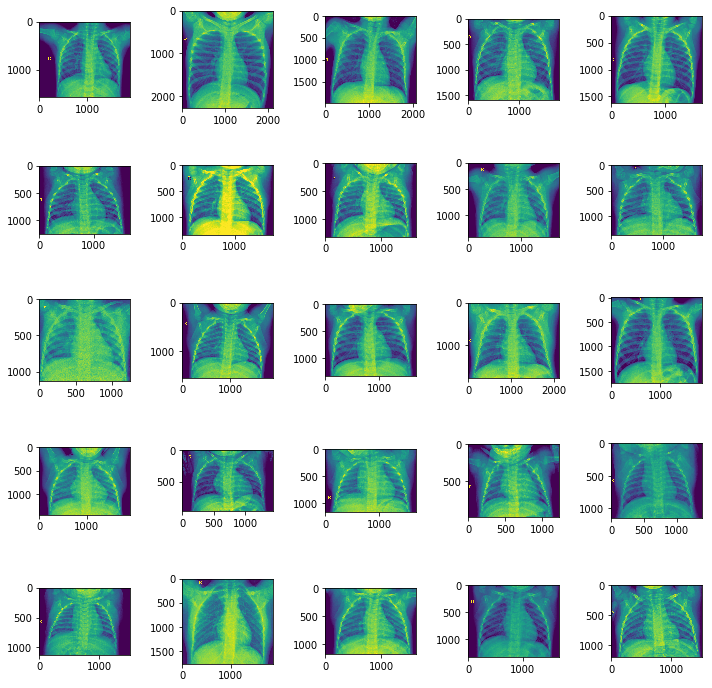

In [23]:
plot_imgs(train_nrml_pth)

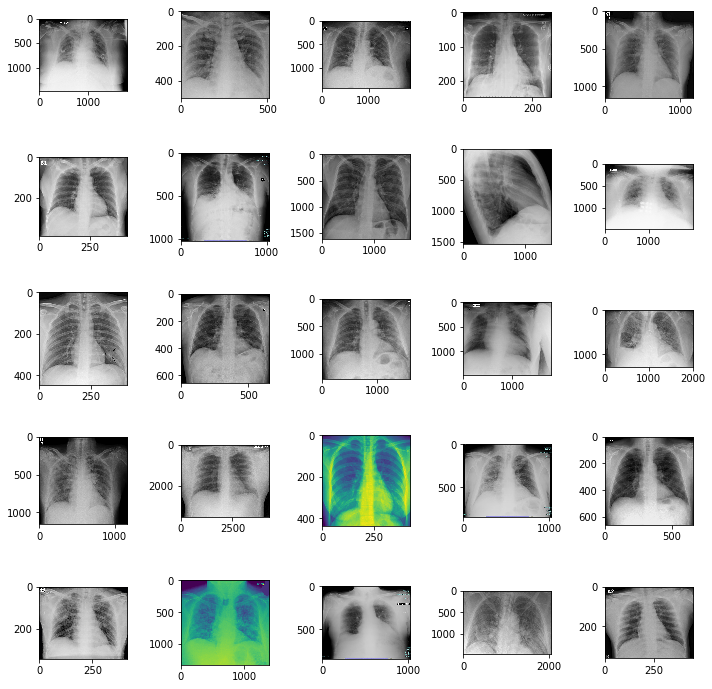

In [24]:
plot_imgs(train_covid19_pth)

## Histogram with Mathplotlib

In [25]:
def plot_img_hist(item_dir, num_img=6):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_img]
  
  #plt.figure(figsize=(10, 10))
  for idx, img_path in enumerate(item_files):
    fig1 = plt.figure(idx,figsize=(10, 10))
    fig1.add_subplot(2, 2, 1)
    img = mpimg.imread(img_path, )
    plt.imshow(img)
    fig1.add_subplot(2, 2, 2)
    plt.hist(img.ravel(),bins=256, fc='k', ec='k')
  
  plt.tight_layout()

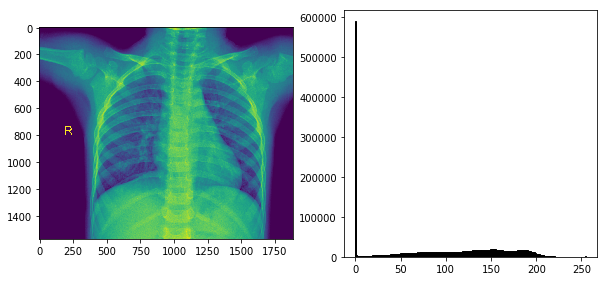

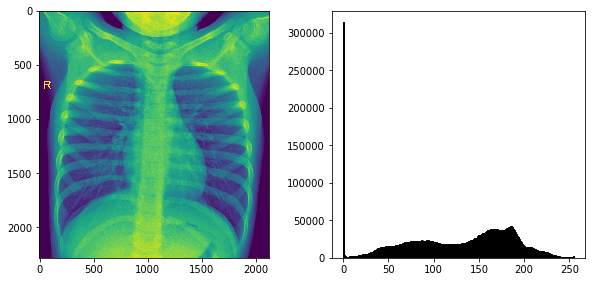

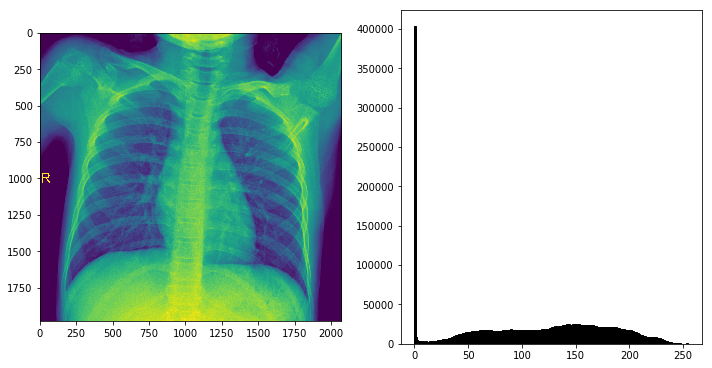

In [26]:
plot_img_hist(train_nrml_pth,3)

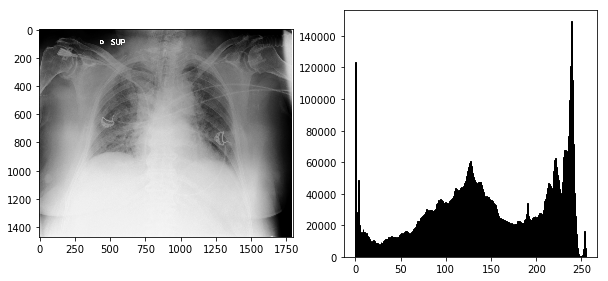

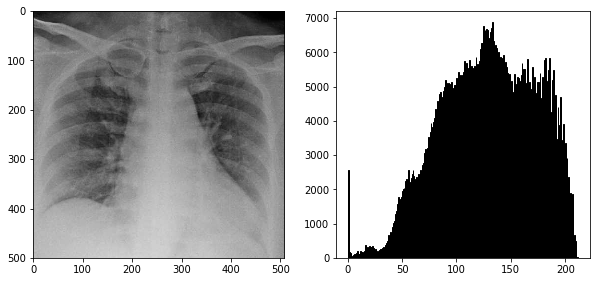

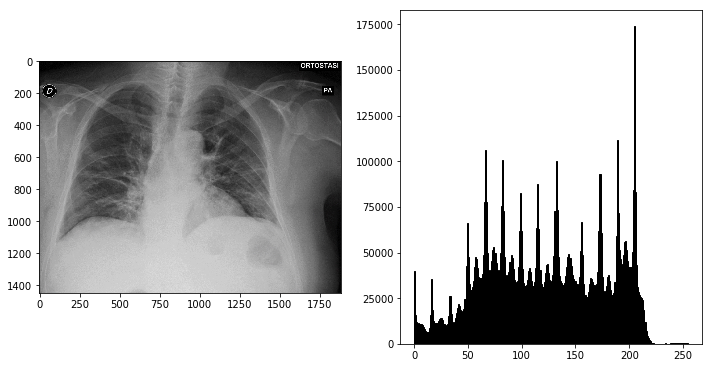

In [27]:
plot_img_hist(train_covid19_pth,3)

In [28]:
def plot_img_hist_ndi(item_dir, num_img=6):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_img]
  
  #plt.figure(figsize=(10, 10))
  for idx, img_path in enumerate(item_files):
    im = imageio.imread(img_path)
    hist = ndi.histogram(im, min=0, max=255, bins=256)
    cdf = hist.cumsum() / hist.sum()
    
    fig1 = plt.figure(idx,figsize=(10, 10))
    fig1.add_subplot(2, 3, 1)
    img = mpimg.imread(img_path, )
    plt.title("No. {}".format(idx))
    plt.imshow(img)
    fig1.add_subplot(2, 3, 2)
    plt.title("Histogram")
    plt.plot(hist)
    fig1.add_subplot(2, 3, 3)
    plt.title("CDF")
    plt.plot(cdf)

  plt.tight_layout()

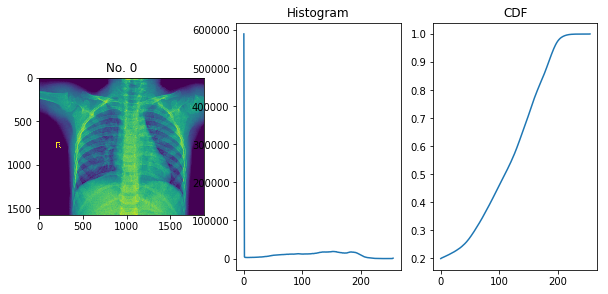

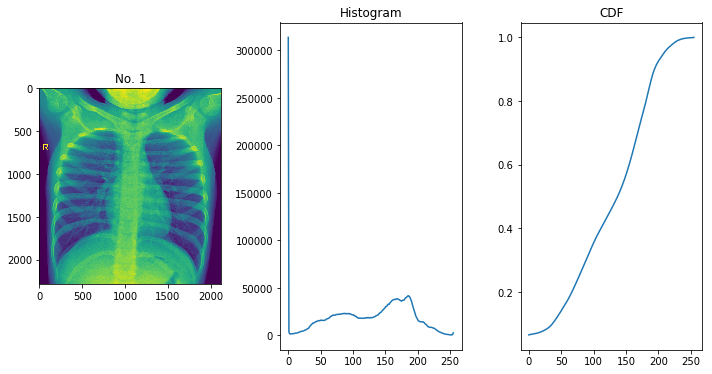

In [29]:
plot_img_hist_ndi(train_nrml_pth,2)

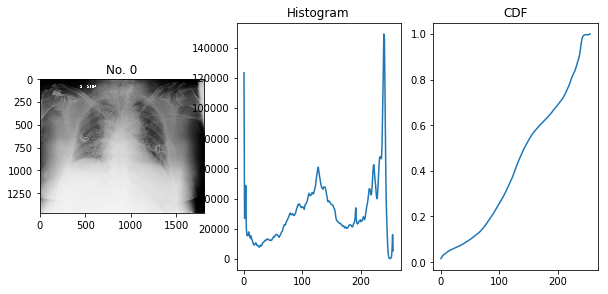

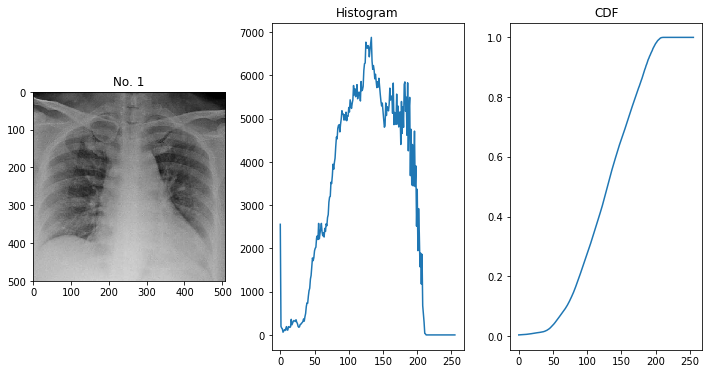

In [30]:
plot_img_hist_ndi(train_covid19_pth,2)

# Data Preperation

In [31]:

train_dir = r'/kaggle/corona_check/train/'
test_dir = r'/kaggle/corona_check/test/'

## Model Params

image_size = 150
batch_size = 50
nb_classes = 2

train_datagen = ImageDataGenerator(rescale = 1./255,     # Convert all pixels to 0-1
                              width_shift_range = 0.1,   # The magnitude of the horizontal shift of the picture when the data is improved
                              height_shift_range = 0.1,  # The magnitude of the vertical shift of the picture when the data is boosted
                              shear_range = 0.2,         # Set the shear strength
                              horizontal_flip = True,    # Randomly select half of the picture to flip horizontally
                              fill_mode ='nearest')      #The points that exceed the boundary will be processed according to the method given by this parameter.Generally, there are some  
                                                         # ‘constant’，‘nearest’，‘reflect’或‘wrap。

test_datagen = ImageDataGenerator(rescale = 1./255)

In [32]:
print(test_dir)

/kaggle/corona_check/test/


In [33]:
print("traning set: ")

# Generate batches of tensor image data through real-time data augmentation. Data will be continuously cycled (by batch)

train_datagen = train_datagen.flow_from_directory(train_dir,              # The path to the target directory. Each class should contain a subdirectory. Any PNG, JPG, BMP, PPM or TIF images in the subdirectory tree will be included in the raw
                                               (image_size, image_size),  # Integer tuple (height, width), default: (256, 256). All images will be resized 
                                               batch_size=batch_size,     # The size of the batch of data (default 32)
                                               class_mode='categorical')  # class_mode is one of categorical "," binary "," sparse "or None, which determines the array form of the returned tags. categorical returns 2D one-hot encoded tags.
print("testing set: ")

test_datagen = test_datagen.flow_from_directory(test_dir,
                                             (image_size,image_size),
                                              batch_size=batch_size,
                                              class_mode='categorical')


#Define step count

train_steps = train_datagen.samples//batch_size # "//" means integer division
test_steps = test_datagen.samples//batch_size


traning set: 
Found 1388 images belonging to 2 classes.
testing set: 
Found 246 images belonging to 2 classes.


## Neural Architecture

In [34]:
if K.image_data_format()=='channels_first':  # (‘channels_last’,‘channels_first’）
   input_shape =(3,image_size,image_size)
else:
   input_shape =(image_size,image_size,3)   
   
# The input feature is a tensor of 150x150x3, where 150x150 is used for image pixels and 3 is used for three color channels
img_input = layers.Input(shape=input_shape)

#
# The first convolution layer extracts the features of 3x3x32 (size of 2D convolution window: 3x3, output 32 dimensions),
#uses a linear rectification function (Rectified Linear Unit, ReLU), and then the largest pooling layer with a size of 2x2

x = layers.Conv2D(32,3,activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


# Flatten the feature map into a one-dimensional data (`1-dim`) tensor to add a fully connected layer (dense)

x = layers.Flatten()(x)


# Use `sigmoid` activation function and 128 neurons to create a fully connected layer

x = layers.Dense(128,activation='sigmoid')(x)

# Randomly disconnect the input neural cloud with a certain probability to prevent overfitting
x = layers.Dropout(0.5)(x)                       


# Create output layer with 2 neurons and `softmax` activation function

output = layers.Dense(2,activation='softmax')(x)

model= Model(img_input,output)

model.summary()                  

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0   

## Configuring Metrics and Model training params for Neural Networks

In [35]:
# Define corresponding parameters for the model
model.compile(loss='categorical_crossentropy', # Multi-class logarithmic loss. Note that when using this objective function, labels need to be converted into binary sequences of the form (nb_samples, nb_classes).
              optimizer =Adam(lr=0.0001),
              metrics = ['acc'] )              # Metrics list metrics: For classification problems, we generally set the list to metrics = ['accuracy']


# Set the corresponding number of training iterations

epochs = 20


# Training model
history = model.fit_generator(train_datagen,
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             validation_data=test_datagen,
                             validation_steps=test_steps )   

Epoch 1/20
27/27 [==============================] - 42s 2s/step - loss: 0.1745 - acc: 0.9634 - val_loss: 0.0947 - val_acc: 0.9450
Epoch 2/20
27/27 [==============================] - 41s 2s/step - loss: 0.1426 - acc: 0.9709 - val_loss: 0.2550 - val_acc: 0.9541
Epoch 3/20
27/27 [==============================] - 38s 1s/step - loss: 0.1374 - acc: 0.9641 - val_loss: 0.3697 - val_acc: 0.9388
Epoch 4/20
27/27 [==============================] - 38s 1s/step - loss: 0.1080 - acc: 0.9686 - val_loss: 0.1297 - val_acc: 0.9694
Epoch 5/20
27/27 [==============================] - 38s 1s/step - loss: 0.0851 - acc: 0.9664 - val_loss: 0.2099 - val_acc: 0.9490
Epoch 6/20
27/27 [==============================] - 38s 1s/step - loss: 0.0509 - acc: 0.9791 - val_loss: 0.0888 - val_acc: 0.9550
Epoch 7/20
27/27 [==============================] - 40s 1s/step - loss: 0.0600 - acc: 0.9776 - val_loss: 0.0582 - val_acc: 0.9592
Epoch 8/20
27/27 [==============================] - 39s 1s/step - loss: 0.0505 - acc: 0.98

## Assess Metrics and Accuracy 

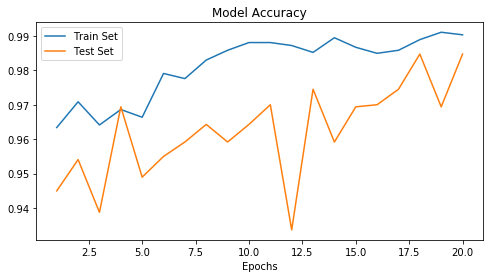

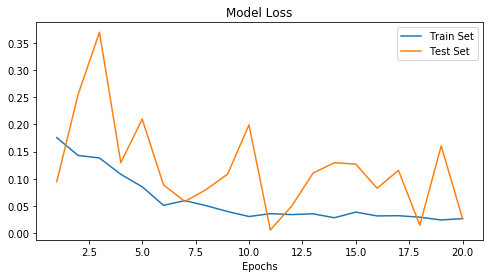

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

In [37]:
# Evaluate the model to get the corresponding Accuracy, Precision, and Recall

Y_pred = model.predict_generator(test_datagen,test_steps+1)
y_pred = np.argmax(Y_pred,axis=1)

CM =confusion_matrix(test_datagen.classes,y_pred)
print("Confusion Matrix :")
print(CM)

pneumonia_precision= CM[1][1] / (CM[1][0]+CM[1][1])
print("pnuemonia_precision:", pneumonia_precision)

pnuemonia_recall = CM[1][1] / (CM[1][1]+CM[0][1])
print('pnuemonia_recall   :', pnuemonia_recall)

accuracy = (CM[0][0]+CM[1][1])/(CM[0][0]+CM[0][1]+CM[1][0]+CM[1][1])
print('Accuracy           :', accuracy)

target_names = ['Normal', 'COVID19'] 
print(classification_report(test_datagen.classes, y_pred, target_names=target_names))

Confusion Matrix :
[[  0  12]
 [  9 225]]
pnuemonia_precision: 0.9615384615384616
pnuemonia_recall   : 0.9493670886075949
Accuracy           : 0.9146341463414634
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        12
     COVID19       0.95      0.96      0.96       234

    accuracy                           0.91       246
   macro avg       0.47      0.48      0.48       246
weighted avg       0.90      0.91      0.91       246

